# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](https://github.com/hse-ds/iad-intro-ds/blob/master/2023/homeworks/hw07-trees/meme.jpg?raw=1) -->
<img src="https://github.com/hse-ds/iad-intro-ds/blob/master/2023/homeworks/hw07-trees/meme.jpg?raw=1" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
def entropy_function(a: list):
  p = np.array(a) / sum(a)
  logp = np.log(p)
  res = -np.sum(np.multiply(p, logp))
  return float('{:.2f}'.format(res))

In [3]:
entropy_function([8, 2])

0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [4]:
def gini_function(a: list):
  p = np.array(a) / sum(a)
  res = np.sum(np.multiply(p, 1-p))
  return res

In [5]:
def information_function_gini(a: list, left: list, right: list):
  res = gini_function(a) - (abs(sum(left)) / abs(sum(a))) * gini_function(left) - (abs(sum(right)) / abs(sum(a))) * gini_function(right)
  return float('{:.2f}'.format(res))

In [6]:
information_function_gini([8, 2], [8, 0], [0, 2])

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [7]:
a = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
res = np.mean(a)
float('{:.2f}'.format(res))

40.6

-----
-----

In [8]:
def Hregression(a: np.ndarray):
  return np.var(a)

In [9]:
def split_node_real_left(df: np.ndarray, Xfeature: str, t: float):
  mask_left = df[Xfeature] < t
  return df[mask_left]

In [10]:
def split_node_real_right(df: np.ndarray, Xfeature: str, t: float):
  mask_right = df[Xfeature] >= t
  return df[mask_right]

In [11]:
def split_node_cat_left(df: np.ndarray, Xfeature: str, t):
  mask_left = df[Xfeature] == t
  return df[mask_left]

In [12]:
def split_node_cat_right(df: np.ndarray, Xfeature: str, t):
  mask_right = df[Xfeature] != t
  return df[mask_right]

In [13]:
def balance_class(a: np.array, target_value: str):
  unique = a[target_value].value_counts()
  unique = pd.DataFrame(unique)
  unique = list(unique[target_value])
  return unique

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [14]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [15]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    if task == "classification" and feature_type == "real":
      b10 = np.unique(feature_vector)
      b10 = np.sort(b10)
      b11 = b10[1:]
      tarray = (b10[:len(b10) - 1] + b11) / 2

      myX = np.array(feature_vector)
      myY = np.array(target_vector)
      column_values = ['myX', 'myY']
      df = pd.DataFrame({'myX': myX, 'myY': myY})

      len_initial = len(df)
      balance_initial = balance_class(df, 'myY')
      gini_initial = gini_function(balance_initial)

      Q_list = []

      for i in tarray:
        left_array = split_node_real_left(df, 'myX', i)
        right_array = split_node_real_right(df, 'myX', i)
        len_left = len(left_array)
        len_right = len(right_array)
        balance_left = balance_class(left_array, 'myY')
        balance_right = balance_class(right_array, 'myY')
        gini_left = gini_function(balance_left)
        gini_right = gini_function(balance_right)
        Q_loop = gini_initial - (len_left / len_initial) * gini_left - (len_right / len_initial) * gini_right
        Q_list.append(Q_loop)
      Q_array = np.array(Q_list)
      Q_optimal = np.max(Q_list)
      t_optimal = tarray[np.argmax(Q_list)]
      return [tarray, Q_array, t_optimal, Q_optimal]



    elif task == "classification" and feature_type == "categorical":
      b10 = np.unique(feature_vector)
      tarray = np.sort(b10)

      myX = np.array(feature_vector)
      myY = np.array(target_vector)
      column_values = ['myX', 'myY']
      df = pd.DataFrame({'myX': myX, 'myY': myY})

      len_initial = len(df)
      balance_initial = balance_class(df, 'myY')
      gini_initial = gini_function(balance_initial)

      Q_list = []

      for i in tarray:
        left_array = split_node_cat_left(df, 'myX', i)
        right_array = split_node_cat_right(df, 'myX', i)
        len_left = len(left_array)
        len_right = len(right_array)
        balance_left = balance_class(left_array, 'myY')
        balance_right = balance_class(right_array, 'myY')
        gini_left = gini_function(balance_left)
        gini_right = gini_function(balance_right)
        Q_loop = gini_initial - (len_left / len_initial) * gini_left - (len_right / len_initial) * gini_right
        Q_list.append(Q_loop)
      Q_array = np.array(Q_list)
      Q_optimal = np.max(Q_list)
      t_optimal = tarray[np.argmax(Q_list)]
      return [tarray, Q_array, t_optimal, Q_optimal]


    elif task == "regression" and feature_type == "real":
      b10 = np.unique(feature_vector)
      b10 = np.sort(b10)
      b11 = b10[1:]
      tarray = (b10[:len(b10) - 1] + b11) / 2

      myX = np.array(feature_vector)
      myY = np.array(target_vector)
      column_values = ['myX', 'myY']
      df = pd.DataFrame({'myX': myX, 'myY': myY})

      len_initial = len(df)
      H_regression_initial = np.var(df['myY'])

      Q_list = []

      for i in tarray:
        left_array = split_node_real_left(df, 'myX', i)
        right_array = split_node_real_right(df, 'myX', i)
        len_left = len(left_array)
        len_right = len(right_array)
        H_regression_left = np.var(left_array['myY'])
        H_regression_right = np.var(right_array['myY'])
        Q_loop = H_regression_initial - (len_left / len_initial) * H_regression_left - (len_right / len_initial) * H_regression_right
        Q_list.append(Q_loop)
      Q_array = np.array(Q_list)
      Q_optimal = np.max(Q_list)
      t_optimal = tarray[np.argmax(Q_list)]
      return [tarray, Q_array, t_optimal, Q_optimal]

    
    elif task == "regression" and feature_type == "categorical":
      b10 = np.unique(feature_vector)
      tarray = np.sort(b10)

      myX = np.array(feature_vector)
      myY = np.array(target_vector)
      column_values = ['myX', 'myY']
      df = pd.DataFrame({'myX': myX, 'myY': myY})

      len_initial = len(df)
      H_regression_initial = np.var(df['myY'])

      Q_list = []

      for i in tarray:
        left_array = split_node_cat_left(df, 'myX', i)
        right_array = split_node_cat_right(df, 'myX', i)
        len_left = len(left_array)
        len_right = len(right_array)
        H_regression_left = np.var(left_array['myY'])
        H_regression_right = np.var(right_array['myY'])
        Q_loop = H_regression_initial - (len_left / len_initial) * H_regression_left - (len_right / len_initial) * H_regression_right
        Q_list.append(Q_loop)
      Q_array = np.array(Q_list)
      Q_optimal = np.max(Q_list)
      t_optimal = tarray[np.argmax(Q_list)]
      return [tarray, Q_array, t_optimal, Q_optimal]


    pass

Эту функцию можно протестировать на датасете `California`.

In [16]:
from sklearn.datasets import fetch_california_housing

In [17]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [18]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

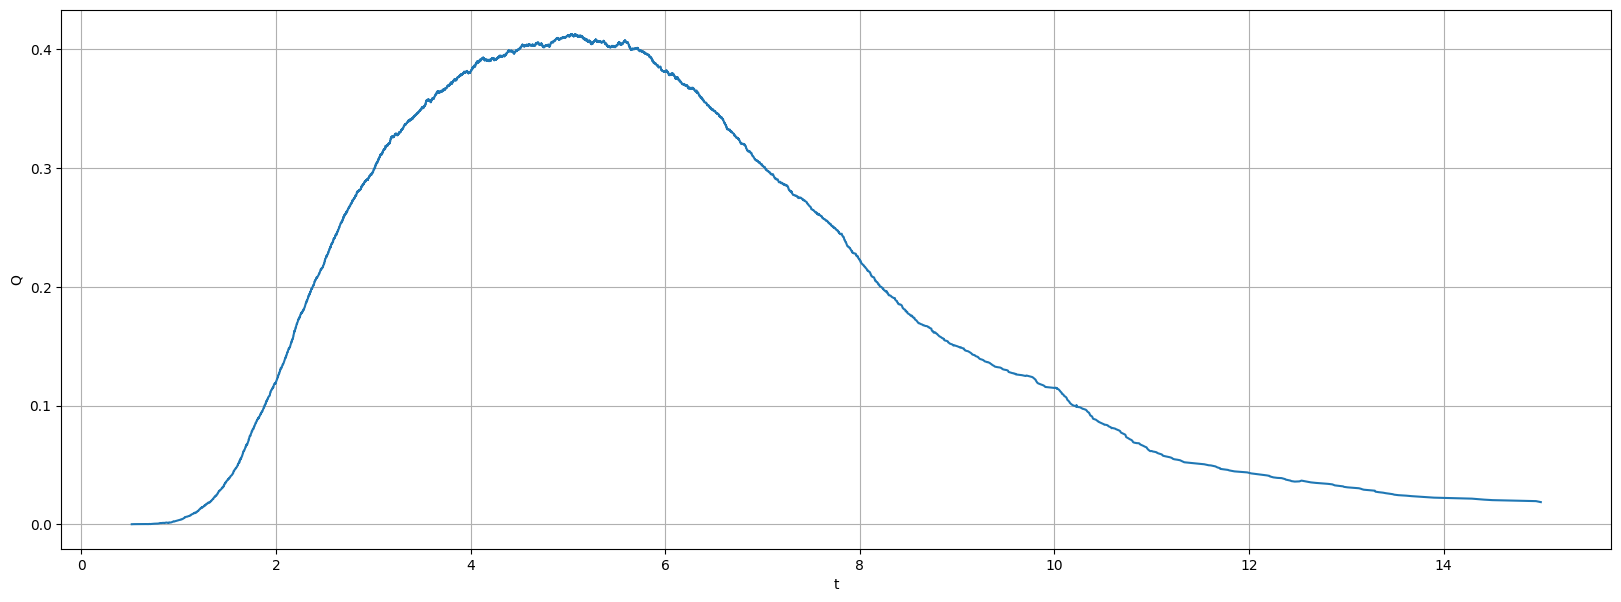

In [20]:
MedInc_split_regression = find_best_split(X['MedInc'], y, "regression", "real")


plt.figure(figsize = (20, 7))
plt.grid()
plt.plot(MedInc_split_regression[0], MedInc_split_regression[1])
plt.ylabel('Q')
plt.xlabel('t');

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [21]:
find_best_split(X['MedInc'], y, "regression", "real")

[array([ 0.51795,  0.54275,  0.5964 , ..., 14.7421 , 14.95045, 15.00005]),
 array([0.0001088 , 0.0001856 , 0.0002249 , ..., 0.0199786 , 0.01956096,
        0.01872587]),
 5.03515,
 0.4127513862016769]

-----
-----

Вывод: лучший предикат: 5.03515

-----
-----

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [17]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная, если вы решите делать бонус
        self._feature_importances = {}
        

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = (sub_X[feature_best] < threshold)
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = (sub_X[feature_best] == threshold)
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if len(node) == 1:
            return node["feature_split"]
            
        if self._feature_types[feature_best] == "categorical":
          if x[node["feature_split"]] == node["category_split"]:
            return self._predict_node(x, node=node["left_child"])
          else:
            return self._predict_node(x, node["right_child"])
        elif self._feature_types[feature_best] == "real":
          if x[node["feature_split"]] < node["threshold"]:
            return self._predict_node(x, node=node["left_child"])
          else:
            return self._predict_node(x, node["right_child"])
        pass

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [17]:
students = pd.read_csv('students.csv')

feature_columns = ['STG', 'SCG', 'STR', 'LPR', 'PEG']
target_column = 'UNS'

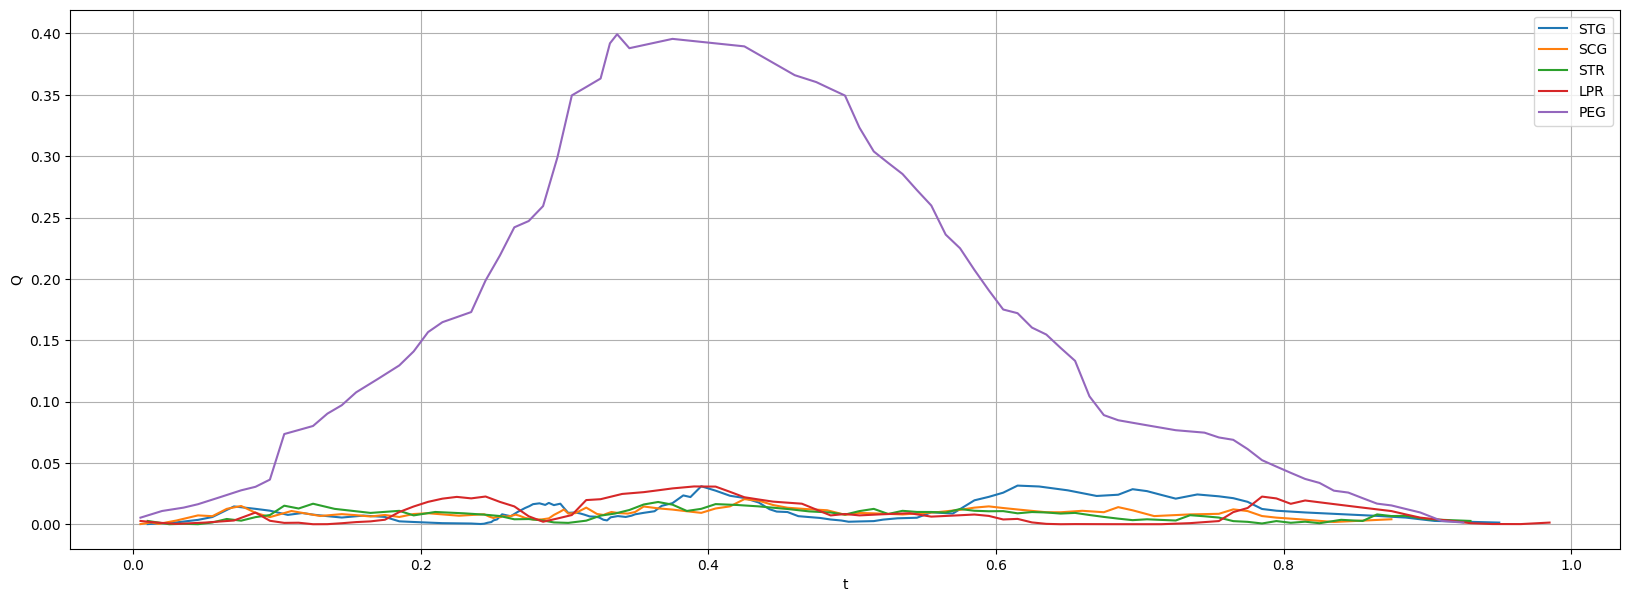

In [18]:
line1 = find_best_split(students['STG'], students['UNS'], "classification", "real")
line2 = find_best_split(students['SCG'], students['UNS'], "classification", "real")
line3 = find_best_split(students['STR'], students['UNS'], "classification", "real")
line4 = find_best_split(students['LPR'], students['UNS'], "classification", "real")
line5 = find_best_split(students['PEG'], students['UNS'], "classification", "real")

plt.figure(figsize = (20, 7))
plt.grid()
plt.plot(line1[0], line1[1], label = 'STG')
plt.plot(line2[0], line2[1], label = 'SCG')
plt.plot(line3[0], line3[1], label = 'STR')
plt.plot(line4[0], line4[1], label = 'LPR')
plt.plot(line5[0], line5[1], label = 'PEG')
plt.ylabel('Q')
plt.xlabel('t')
plt.legend();

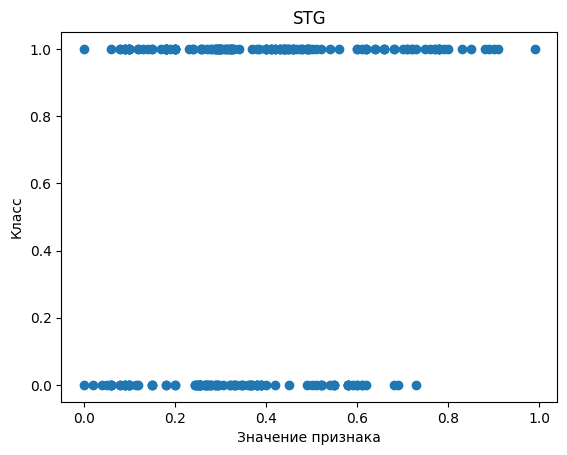

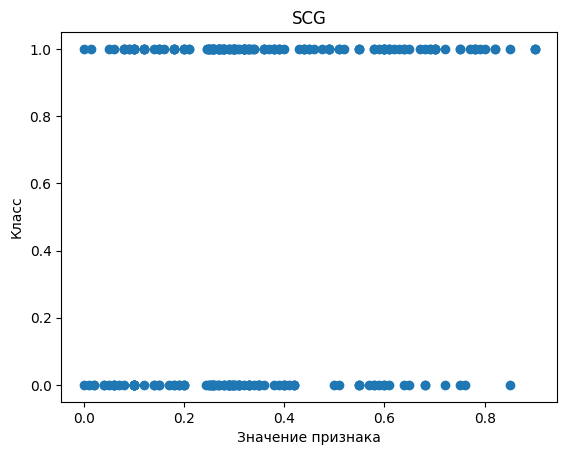

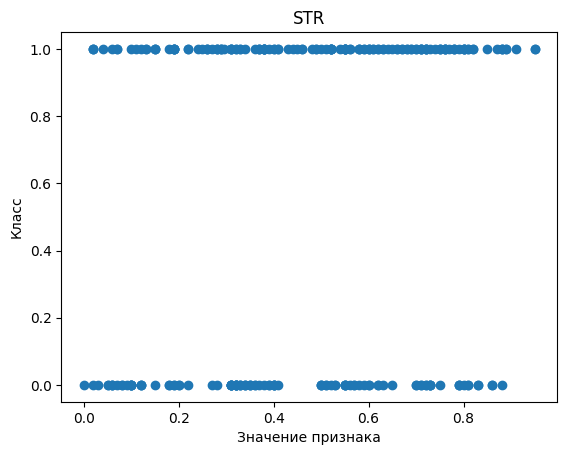

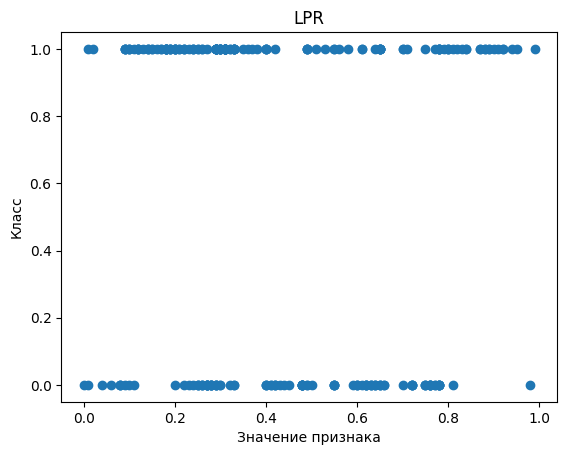

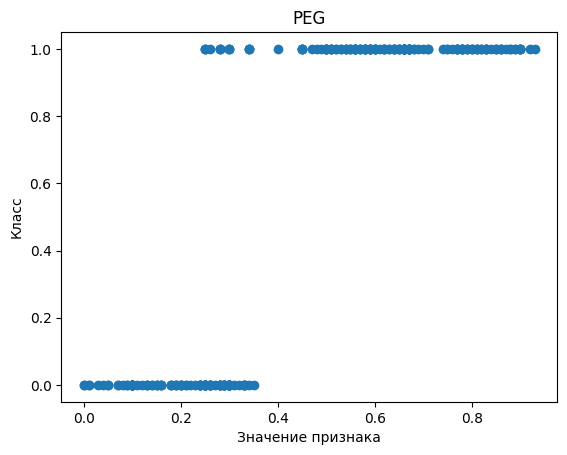

In [35]:
for i in students.columns[1:6]:
  plt.scatter(students[i], students['UNS'])
  plt.ylabel('Класс')
  plt.xlabel('Значение признака')
  plt.title(i)
  plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

-----
-----

Вывод: исходя из критерия информативности, лучшим признаком для разбиения является 'PEG'. Он относится к "хорошим" признакам: на диаграмме рассеяния значение признака "0" заканчивается там, где начинается значение "1", следовательно, с помощью границы двух значений выборку можно разделить почти идеально. У других признаков граница не прослеживается явно, что подтверждает оптимальность признака 'PEG'.

Анализируя призннак 'PEG', можно определить, как должна выглядеть "хорошая" кривая: на ней должен отчётливо выделяться максимум критерия информативности. На других кривых можно увидеть цикличность, которая не позволяет выделить оптимальный порог разбиения и делает деление практически невозможным.

-----
-----

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [31]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

mdf = pd.read_csv('agaricus-lepiota.data')

In [32]:
mdf.apply(preprocessing.LabelEncoder().fit_transform)

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,0,3,2,4,0,5,0,0,0,11,...,2,5,5,0,1,1,4,0,1,2
8119,0,5,2,4,0,5,0,0,0,11,...,2,5,5,0,0,1,4,0,4,2
8120,0,2,2,4,0,5,0,0,0,5,...,2,5,5,0,1,1,4,0,1,2
8121,1,3,3,4,0,8,1,0,1,0,...,1,7,7,0,2,1,0,7,4,2


In [38]:
X = mdf.drop('p', axis=1)
y = mdf['p']
X = np.array(X)
y = np.array(y)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

dtr = DecisionTree(np.array(['categorical'] * len(X[1])))
dtr.fit(X = X_train, y = y_train)
dtr.predict(X_test)

IndexError: ignored

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [1]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [5]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

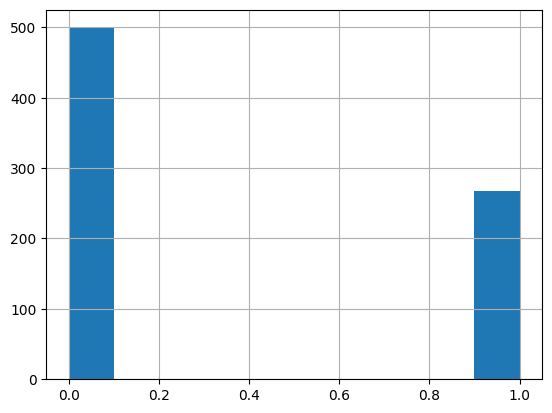

In [6]:
data['Outcome'].hist()
plt.show()

In [8]:
[sum(data['Outcome'] == 0), sum(data['Outcome'] == 1)]

[500, 268]

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [ ]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=123)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from tqdm.auto import trange

In [ ]:
max_depth = 51
min_samples_leaf = 51
mxmnlist = []
train_loss = []
val_loss = []

for i in trange(1, max_depth):
  for j in trange(1, min_samples_leaf):
    dtc = DecisionTreeClassifier(max_depth=i, min_samples_leaf = j, random_state=123)
    dtc.fit(X_train1, y_train1)
    mxmnlist.append((i, j))
    train_loss.append(f1_score(y_train1, dtc.predict(X_train1)))
    val_loss.append(f1_score(y_val, dtc.predict(X_val)))
res = dict(zip(mxmnlist, val_loss))

sorted_res = sorted(res.items(), key=lambda x:x[1], reverse=True)
sorted_res = dict(sorted_res)
print("The best f1: ", sorted_res[list(sorted_res)[0]])
print("Optimal max_depth and min_samples_leaf: ", list(sorted_res)[0])

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

The best f1:  0.616822429906542
Optimal max_depth and min_samples_leaf:  (3, 1)


In [ ]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

dtc = DecisionTreeClassifier(max_depth=list(sorted_res)[0][0], min_samples_leaf = list(sorted_res)[0][1], random_state=123)
dtc.fit(X_train, y_train)
print("Accuracy: ", (accuracy_score(y_test, dtc.predict(X_test))))
print("Precision: ",(precision_score(y_test, dtc.predict(X_test))))
print("Recall: ",(recall_score(y_test, dtc.predict(X_test))))
print("AUC ROC: ",(roc_auc_score(y_test, dtc.predict(X_test))))

Accuracy:  0.7272727272727273
Precision:  0.8571428571428571
Recall:  0.3409090909090909
AUC ROC:  0.6529720279720279


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [ ]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

bc = BaggingClassifier(n_estimators=50, random_state=123)
bc.fit(X_train, y_train)
print("Accuracy: ", (accuracy_score(y_test, bc.predict(X_test))))
print("Precision: ",(precision_score(y_test, bc.predict(X_test))))
print("Recall: ",(recall_score(y_test, bc.predict(X_test))))
print("AUC ROC: ",(roc_auc_score(y_test, bc.predict(X_test))))

Accuracy:  0.7835497835497836
Precision:  0.7209302325581395
Recall:  0.7045454545454546
AUC ROC:  0.7683566433566434


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [ ]:
from sklearn.model_selection import GridSearchCV


X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

rf = RandomForestClassifier()
grid_space = {
    "max_depth": list(range(1, 5)),
    "min_samples_split": list(range(2, 5)),
}

grid_search = GridSearchCV(rf, param_grid = grid_space, cv=5, scoring='f1', error_score='raise')
grid_result = grid_search.fit(X_train, y_train)
grid_result.best_params_
rf_optimal_max_depth = grid_result.best_params_['max_depth']
rf_optimal_min_samples_split = grid_result.best_params_['min_samples_split']
print("The best mean score: ", grid_result.best_score_)
print("Optimal max_depth and min_samples_split: ", grid_result.best_params_)

The best mean score:  0.5638781557425625
Optimal max_depth and min_samples_split:  {'max_depth': 4, 'min_samples_split': 2}


In [ ]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

rf = RandomForestClassifier(n_estimators=50, 
                            random_state=123, max_depth = rf_optimal_max_depth, 
                            min_samples_split = rf_optimal_min_samples_split)
rf.fit(X_train, y_train)
print("Accuracy: ", (accuracy_score(y_test, rf.predict(X_test))))
print("Precision: ",(precision_score(y_test, rf.predict(X_test))))
print("Recall: ",(recall_score(y_test, rf.predict(X_test))))
print("AUC ROC: ",(roc_auc_score(y_test, rf.predict(X_test))))

Accuracy:  0.7662337662337663
Precision:  0.7833333333333333
Recall:  0.5340909090909091
AUC ROC:  0.7215909090909092


-----
-----

Вывод: сравним три рассмотренных модели: решающее дерево с подбором гиперпараметров на валидационной выборке (1), BaggingClassifier (2) и случайный лес с подбором гиперпараметров с помощью кросс-валидации (3).

Рассмотрим четыре метрики.

Precision: [0.86, 0.72, 0.78]. Можно сказать, что при a(x) = 1, то есть при ответе модели "у пациента есть диабет", больше всего стоит доверять первой модели, меньше всего -- второй модели. Впрочем, значения для всех моделей достаточно высокие.

Recall: [0.34, 0.70, 0.53]. Можно сказать, что первая модель выявляет очень мало случаев диабета у пациентов (значение recall очень низкое). Немного больше выявляет третья модель, а вторая модель справляется с выявлением лучше всего.

Accuracy: [0.73, 0.78, 0.77]. У всех моделей похожий результат. Немного хуже себя показывает первая модель, у второй показатель самый высокий. Впрочем, на accuracy мог повлиять определённый дисбаланс классов: среди 768 пациентов только у 268 есть диабет.

AUC ROC: [0.65, 0.77, 0.72]. У первой модели наименьшая площадь под ROC кривой, у второй -- наибольшая.

Общий итог: поскольку мы рассматриваем задачу медицинской диагностики, для нас не выявить диабет у больного человека является более существенной ошибкой, чем определить, что у здорового человека есть диабет. Следовательно, для нас наиболее значима метрика recall, поэтому предпочтительнее всего будет BaggingClassifier. Менее подходящим будет случайный лес с подбором гиперпараметров с помощью кросс-валидации. Решающее дерево с подбором гиперпараметров на валидационной выборке для нашей задачи уступает двум другим моделям. Результаты подтверждаются метрикой AUC ROC, а также метрикой accuracy.

-----
-----

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

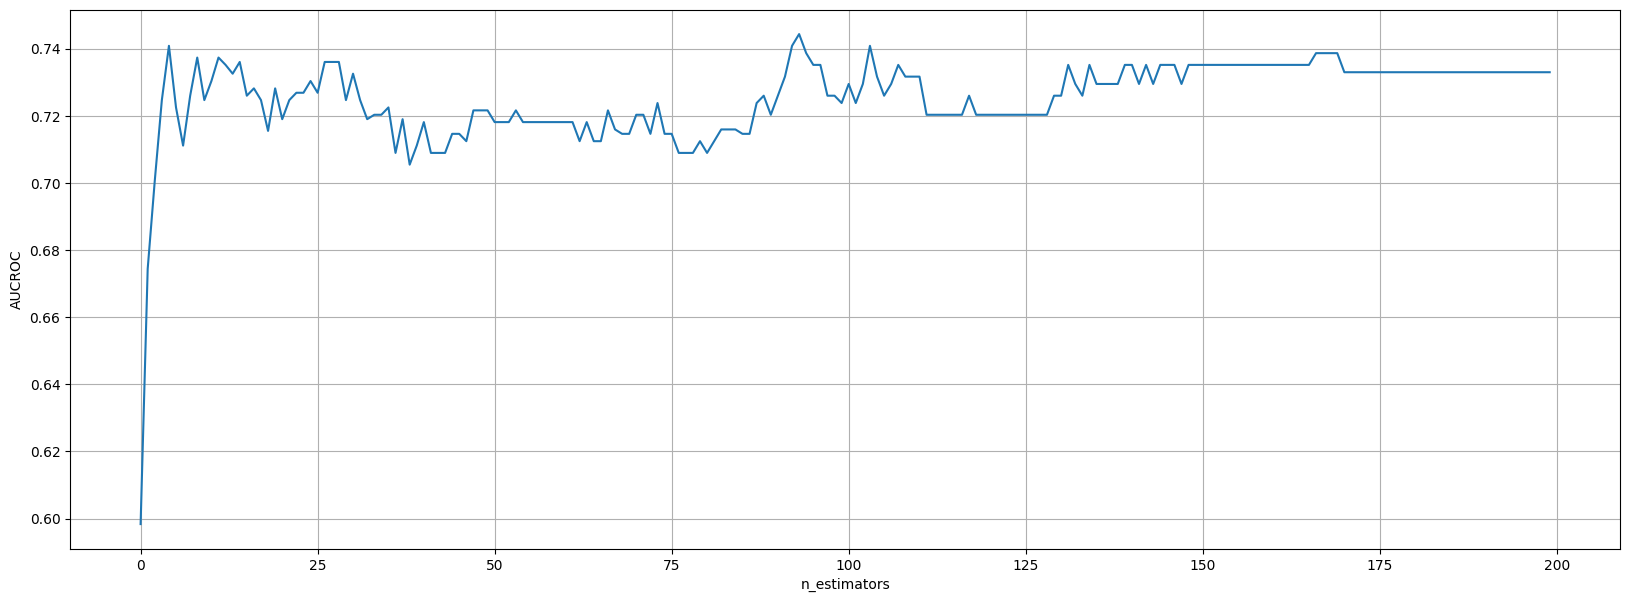

In [ ]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

AUCROC_list = []
max_n_estimators = 201
for i in range(1, max_n_estimators):
  rf = RandomForestClassifier(n_estimators=i, 
                            random_state=123, max_depth = rf_optimal_max_depth, 
                            min_samples_split = rf_optimal_min_samples_split)
  rf.fit(X_train, y_train)
  AUCROC_list.append(roc_auc_score(y_test, rf.predict(X_test)))

plt.figure(figsize = (20, 7))
plt.grid()
plt.plot(AUCROC_list)
plt.ylabel('AUCROC')
plt.xlabel('n_estimators');

-----
-----

Вывод: 5-10 деревьев уже дают высокий показатель AUC ROC. В дальнейшем показатель существенно не улучшается, а на определённых интервалах (например, 175-190 деревьев) остаётся неизменным

-----
-----

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

<BarContainer object of 8 artists>

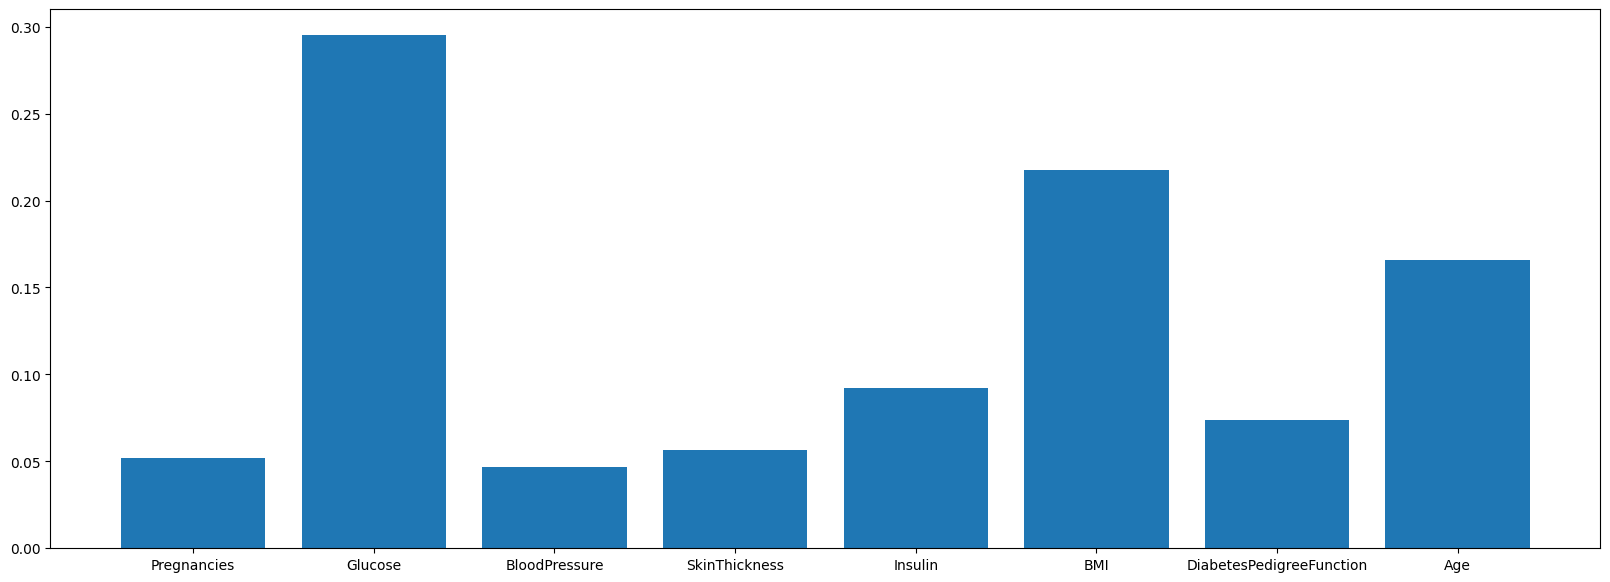

In [ ]:
rf = RandomForestClassifier(n_estimators=50, 
                            random_state=123, max_depth = rf_optimal_max_depth, 
                            min_samples_split = rf_optimal_min_samples_split)
rf.fit(X_train, y_train)
plt.figure(figsize = (20, 7))
plt.bar(data.iloc[:, 0:8].columns, rf.feature_importances_)

-----
-----

Вывод: самым важным признаком для определения диабета оказался Glucose, отражающий концентрацию глюкозы в плазме через 2 часа при тесте на толерантность к глюкозе

-----
-----